In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

import geopandas as gpd

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()



In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# Distressed Tracts By County
`civicknowledge.com-distressed-county-1.1.5` Last Update: 2020-06-24T21:43:08

_Counts of FFEIC distressed tracts, by county._


The [FFEIC publishes a very large dataset of Census
variables](https://www.ffiec.gov/censusapp.htm) and flags indicating ways in
which housing and populations in tracts are distressed. This dataset aggregates
those tract flags into counts of distressed tracts per county.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)


## References
<ul><li> <strong>ffeic_distressed</string>, <em>metapack+http://library.metatab.org/ffeic.gov-census-tract.csv#ffeic_distressed</em>. Flags indicating FFEIC "distressed" designations, per tract.</li><li> <strong>county_500k</string>, <em>metapack+http://library.metatab.org/census.gov-boundaries-2018.csv#county_500k</em>. County Boundaries</li><ul>

In [3]:
counties = pkg.reference('county_500k').geoframe()
counties.head()

,geoid,name,stusab,state_fips,county_fips,land_area,water_area,geometry
0,05000US21007,Ballard,KY,21,7,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,05000US21017,Bourbon,KY,21,17,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,05000US21031,Butler,KY,21,31,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,05000US21065,Estill,KY,21,65,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,05000US21069,Fleming,KY,21,69,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


In [4]:
stusab = counties[['state_fips','stusab']].sort_values(['state_fips','stusab']).drop_duplicates().rename(columns={'state_fips':'state'})

In [5]:
tract = pkg.reference('ffeic_distressed').dataframe()

from geoid.acs import County

tract['county_geoid'] = tract.apply(lambda r: County(r.state, r.county), axis=1)

agg_cols = ['poverty_distressed', 'unemployment_distressed','population_distressed', 
            'rural_underserved', 'last_year_distressed','last_year_underserved', 
            'current_prior_distressed']

for col in agg_cols:

    
    tract[col] = tract[col].replace({'X':1, ' ':0})
    tract[col+'_pop'] = tract[col]*tract.population

tract = tract.merge(stusab)
    

In [6]:
g = tract.groupby('county_geoid')


tract.poverty_distressed.value_counts()


0.0    515485
1.0     15554
Name: poverty_distressed, dtype: int64

In [7]:
tract.columns


Index(['geoid', 'year', 'msa_md_code', 'state', 'county', 'tract',
       'principal_city_flag', 'small_county_flag', 'split_tract_flag',
       'demo_flag', 'urban_rural_flag', 'msa_family_income',
       'msa_household_income', 'tract_household_income',
       'tract_family_income_pct', 'ffeic_median_income', 'population',
       'families', 'households', 'female', 'male', 'nonwhite',
       'minority_percent', 'income_level', 'poverty_distressed',
       'unemployment_distressed', 'population_distressed', 'rural_underserved',
       'last_year_distressed', 'last_year_underserved',
       'current_prior_distressed', 'county_geoid', 'poverty_distressed_pop',
       'unemployment_distressed_pop', 'population_distressed_pop',
       'rural_underserved_pop', 'last_year_distressed_pop',
       'last_year_underserved_pop', 'current_prior_distressed_pop', 'stusab'],
      dtype='object')

In [8]:
agg_cols = ['poverty_distressed', 'unemployment_distressed','population_distressed', 
            'rural_underserved', 'last_year_distressed','last_year_underserved', 
            'current_prior_distressed']
agg_pop_cols = [c+'_pop' for c in agg_cols]


In [9]:
t = tract[['stusab', 'state','county', 'year','population'] + agg_cols + agg_pop_cols].copy()
t['n'] = 1

t = t.groupby(['stusab', 'state','county','year']).sum().reset_index()

all_cols = agg_cols + agg_pop_cols

for c in agg_cols:
    t[c+'_pct'] = (t[c] / t.n * 100).round(2)
    t[c+'_pop_pct'] = (t[c+'_pop'] / t.population * 100).round(2)
    
    all_cols.append(c+'_pct')
    all_cols.append(c+'_pop_pct')
    
t[t.poverty_distressed != 0].head(20).T.head(50)
 
from geoid.acs import County

def a(r):
    return str(County(r.state, r.county))

t['geoid'] = t.apply(a, axis=1)

all_cols = list(sorted(all_cols))

t = t.merge(stusab)

df = t[['geoid', 'stusab', 'state','county','year'] + all_cols].sort_values(['state','county','year'])



In [10]:
df.stusab.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'], dtype=object)

In [20]:
df.head().T

,203,204,205,206,207
geoid,05000US01001,05000US01001,05000US01001,05000US01001,05000US01001
stusab,AL,AL,AL,AL,AL
state,1,1,1,1,1
county,1,1,1,1,1
year,2013,2014,2015,2016,2017
current_prior_distressed,0,0,0,0,0
current_prior_distressed_pct,0,0,0,0,0
current_prior_distressed_pop,0,0,0,0,0
current_prior_distressed_pop_pct,0,0,0,0,0
last_year_distressed,0,0,0,0,0


/Users/eric/opt/anaconda3/envs/metapack/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/eric/opt/anaconda3/envs/metapack/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


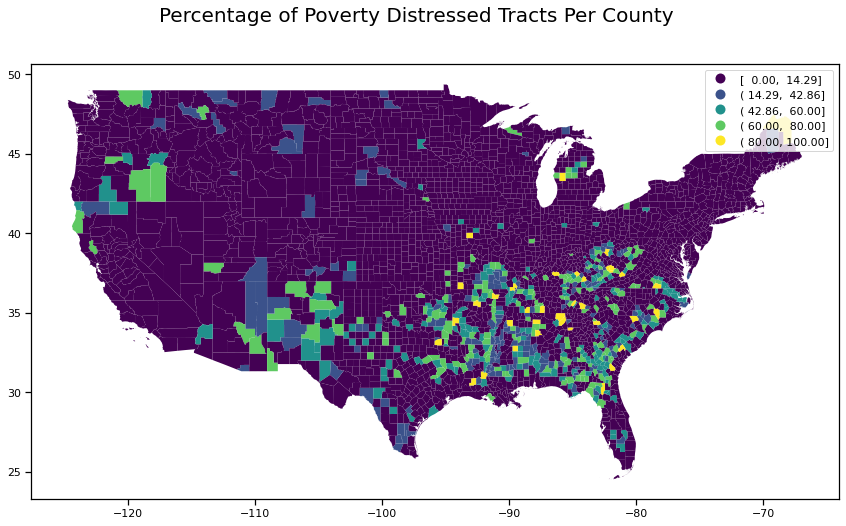

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
  
fig.suptitle("Percentage of Poverty Distressed Tracts Per County", fontsize=20);
    
t = df[(~df.stusab.isin(['HI','AK', 'PR'])) & (df.year == 2016)]
t = counties.merge(t)

t.plot(column='poverty_distressed_pct', ax=ax, legend=True, scheme='fisher_jenks_sampled')

/Users/eric/opt/anaconda3/envs/metapack/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/eric/opt/anaconda3/envs/metapack/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


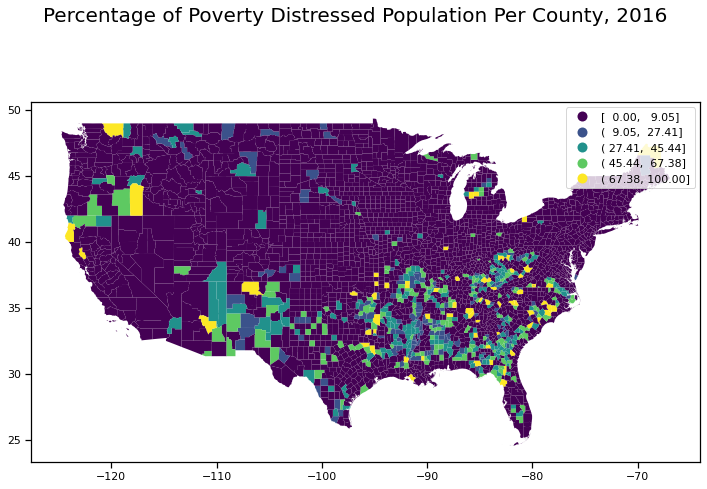

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
  
fig.suptitle("Percentage of Poverty Distressed Population Per County, 2016", fontsize=20);
    
t = df[(~df.stusab.isin(['HI','AK', 'PR'])) & (df.year == 2016)]
t = counties.merge(t)

t.plot(column='poverty_distressed_pop_pct', ax=ax, legend=True, scheme='fisher_jenks_sampled')

fig.savefig('../doc/sample.png')
